In [1]:
#import numpy as np
import numpy.random as npr

import jax
import jax.numpy as jnp 
import jax.random as jrnd
import jax.scipy.stats as jsps
import jax.scipy.linalg as spla
from jax.config import config
config.update("jax_enable_x64", True)
from jax.scipy.stats import gaussian_kde

import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from search_no_gpjax import generate_true_function
from scipy.spatial import ConvexHull

In [2]:
"""
This module provides the ConvexHull class.
"""

import itertools
import numpy as np
from typing import List, Sized, Union
from scipy.interpolate import griddata
from scipy.spatial import ConvexHull as ConvexHullSciPy
from scipy.spatial.qhull import QhullError

class ConvexHullMod:
    """This class provides functionality for extracting the convex hull
    of the (free) energy of mixing. It is based on the `convex hull
    calculator in SciPy
    <http://docs.scipy.org/doc/scipy-dev/reference/\
generated/scipy.spatial.ConvexHull.html>`_.
    Parameters
    ----------
    concentrations : list(float) or list(list(float))
        concentrations for each structure listed as ``[[c1, c2], [c1, c2],
        ...]``; for binaries, in which case there is only one independent
        concentration, the format ``[c1, c2, c3, ...]`` works as well.
    energies : list(float)
        energy (or energy of mixing) for each structure
    Attributes
    ----------
    concentrations : np.ndarray
        concentrations of the `N` structures on the convex hull
    energies : np.ndarray
        energies of the `N` structures on the convex hull
    dimensions : int
        number of independent concentrations needed to specify a point in
        concentration space (1 for binaries, 2 for ternaries etc.)
    structures : list(int)
        indices of structures that constitute the convex hull (indices are
        defined by the order of their concentrations and energies are fed when
        initializing the ConvexHull object)
    Examples
    --------
    A `ConvexHull` object is easily initialized by providing lists of
    concentrations and energies::
        >>> data = {'concentration': [0,    0.2,  0.2,  0.3,  0.4,  0.5,  0.8,  1.0],
        ...         'mixing_energy': [0.1, -0.2, -0.1, -0.2,  0.2, -0.4, -0.2, -0.1]}
        >>> hull = ConvexHull(data['concentration'], data['mixing_energy'])
    Now one can for example access the points along the convex hull directly::
        >>> for c, e in zip(hull.concentrations, hull.energies):
        ...     print(c, e)
        0.0 0.1
        0.2 -0.2
        0.5 -0.4
        1.0 -0.1
    or plot the convex hull along with the original data using e.g., matplotlib::
        >>> import matplotlib.pyplot as plt
        >>> plt.scatter(data['concentration'], data['mixing_energy'], color='darkred')
        >>> plt.plot(hull.concentrations, hull.energies)
        >>> plt.show(block=False)
    It is also possible to extract structures at or close to the convex hull::
        >>> low_energy_structures = hull.extract_low_energy_structures(
        ...     data['concentration'], data['mixing_energy'],
        ...     energy_tolerance=0.005)
    A complete example can be found in the :ref:`basic tutorial
    <tutorial_enumerate_structures>`.
    """

    def __init__(self,
                 concentrations: Union[List[float], List[List[float]]],
                 energies: List[float]) -> None:
        assert len(concentrations) == len(energies)
        # Prepare data in format suitable for SciPy-ConvexHull
        concentrations = np.array(concentrations)
        energies = np.array(energies)
        points = np.column_stack((concentrations, energies))
        self.dimensions = len(points[0]) - 1

        # Construct convex hull
        hull = ConvexHullSciPy(points,qhull_options='Qs')

        # Collect convex hull points in handy arrays
        concentrations = []  # type: ignore
        energies = []  # type: ignore
        for vertex in hull.vertices:
            if self.dimensions == 1:
                concentrations.append(points[vertex][0])
            else:
                concentrations.append(points[vertex][0:-1])
            energies.append(points[vertex][-1])
        concentrations = np.array(concentrations)
        energies = np.array(energies)

        structures = hull.vertices
        # If there is just one independent concentration, we'd better sort
        # according to it
        if self.dimensions == 1:
            ces = list(zip(*sorted(zip(concentrations, energies, structures))))
            self.concentrations = np.array(ces[0])
            self.energies = np.array(ces[1])
            self.structures = np.array(ces[2])
        else:
            self.concentrations = concentrations
            self.energies = energies
            self.structures = structures

        # Remove points that are above the "pure components plane"
        self._remove_points_above_tie_plane()

    def _remove_points_above_tie_plane(self, tol: float = 1e-3) -> None:
        """
        Remove all points on the convex hull that correspond to maximum rather
        than minimum energy.
        Parameters
        ----------
        tol
            Tolerance for what energy constitutes a lower one.
        """

        # Identify the "complex concentration hull", i.e. the extremal
        # concentrations. In the simplest case, these should simply be the
        # pure components.
        if self.dimensions == 1:
            # Then the ConvexHullScipy function doesn't work, so we just pick
            # the indices of the lowest and highest concentrations.
            vertices = []
            vertices.append(np.argmin(self.concentrations))
            vertices.append(np.argmax(self.concentrations))
            vertices = np.array(vertices)
        else:
            concentration_hull = ConvexHullSciPy(self.concentrations,qhull_options='Qs')
            vertices = concentration_hull.vertices

        # Remove all points of the convex energy hull that have an energy that
        # is higher than what would be gotten with pure components at the same
        # concentration. These points are mathematically on the convex hull,
        # but in the physically uninteresting upper part, i.e. they maximize
        # rather than minimize energy.
        to_delete = []
        for i, concentration in enumerate(self.concentrations):
            # The points on the convex concentration hull should always be
            # included, so skip them.
            if i in vertices:
                continue

            # The energy obtained as a linear combination of concentrations on
            # the convex hull is the "z coordinate" of the position on a
            # (hyper)plane in the (number of independent concentrations +
            # 1)-dimensional (N-D) space. This plane is spanned by N points.
            # If there are more vertices on the convex hull, we need to loop
            # over all combinations of N vertices.
            for plane in itertools.combinations(vertices,
                                                min(len(vertices),
                                                    self.dimensions + 1)):
                # Calculate energy that would be gotten with pure components
                # with ascribed concentration.
                energy_pure = griddata(self.concentrations[np.array(plane)],
                                       self.energies[np.array(plane)],
                                       concentration,
                                       method='linear')

                # Prepare to delete if the energy was lowered. `griddata` gives
                # NaN if the concentration is outside the triangle formed by
                # the three vertices. The result of the below comparison is
                # then False, which is what we want.
                if energy_pure < self.energies[i] - tol:
                    to_delete.append(i)
                    break

        # Finally remove all points
        self.concentrations = np.delete(self.concentrations, to_delete, 0)
        self.energies = np.delete(self.energies, to_delete, 0)
        self.structures = list(np.delete(self.structures, to_delete, 0))

    def get_energy_at_convex_hull(self, target_concentrations:
                                  Union[List[float],
                                        List[List[float]]]) -> np.ndarray:
        """Returns the energy of the convex hull at specified concentrations.
        If any concentration is outside the allowed range, NaN is
        returned.
        Parameters
        ----------
        target_concentrations
            concentrations at target points
            If there is one independent concentration, a list of
            floats is sufficient. Otherwise, the concentrations ought
            to be provided as a list of lists, such as ``[[0.1, 0.2],
            [0.3, 0.1], ...]``.
        """
        if self.dimensions > 1 and isinstance(target_concentrations[0], Sized):
            assert len(target_concentrations[0]) == self.dimensions

        # Loop over all complexes of N+1 points to make sure that the lowest
        # energy plane is used in the end. This is needed in two dimensions
        # but in higher.
        hull_candidate_energies = []
        for plane in itertools.combinations(range(len(self.energies)),
                                            min(len(self.energies),
                                                self.dimensions + 1)):
            try:
                plane_energies = griddata(self.concentrations[list(plane)],
                                          self.energies[list(plane)],
                                          np.array(target_concentrations),
                                          method='linear')
            except QhullError:
                # If the points lie on a line, the convex hull will fail, but
                # we do not need to care about these "planes" anyway
                continue
            hull_candidate_energies.append(plane_energies)

        # Pick out the lowest energies found
        hull_energies = np.nanmin(hull_candidate_energies, axis=0)
        return hull_energies

    def extract_low_energy_structures(self, concentrations:
                                      Union[List[float],
                                            List[List[float]]],
                                      energies: List[float],
                                      energy_tolerance: float) -> List[int]:
        """Returns the indices of energies that lie within a certain
        tolerance of the convex hull.
        Parameters
        ----------
        concentrations
            concentrations of candidate structures
            If there is one independent concentration, a list of
            floats is sufficient. Otherwise, the concentrations must
            be provided as a list of lists, such as ``[[0.1, 0.2],
            [0.3, 0.1], ...]``.
        energies
            energies of candidate structures
        energy_tolerance
            include structures with an energy that is at most this far
            from the convex hull
        """
        # Convert to numpy arrays, can be necessary if, for example,
        # they are Pandas Series with "gaps"
        concentrations = np.array(concentrations)
        energies = np.array(energies)

        n_points = len(concentrations)
        if len(energies) != n_points:
            raise ValueError('concentrations and energies must have '
                             'the same length')

        # Calculate energy at convex hull for specified concentrations
        hull_energies = self.get_energy_at_convex_hull(concentrations)

        # Extract those that are close enough
        close_to_hull = [i for i in range(n_points)
                         if energies[i] <= hull_energies[i] + energy_tolerance]

        return close_to_hull

/var/folders/4v/yjlz4wlj08n26k6x_vpckx500000gn/T/ipykernel_32405/3684881324.py:10: DeprecationWarning: Please use `QhullError` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import QhullError


In [3]:
def convelope(design_space, knot_y):

    N, D = design_space.shape
    deriv_marg_var = 100
    #d_kernel = jax.jit(jax.vmap(jax.grad(jax.grad(lambda x1, x2, ls: kernel_old(x1, x2, ls)[0,0], argnums=0), argnums=1), in_axes=(0,0,None)))
    # TODO: 
    #deriv_marg_var = np.max(jnp.diag(d_kernel(knot_x, knot_x, ls)))
    #print(deriv_marg_var)
    s = jnp.linspace(-3*jnp.sqrt(deriv_marg_var), 3*jnp.sqrt(deriv_marg_var), 500)
    ss = jnp.meshgrid(*[s.ravel()]*D)
    s = jnp.array([sx.flatten() for sx in ss]).T

    knot_y = jnp.atleast_2d(knot_y) # samples x num_primal
    #print(knot_y.shape)
    
    prod = (design_space @ s.T).T
    #print(prod.shape)
    
    # compute the conjugate
    lft1 = jnp.max(prod[jnp.newaxis,:,:] - knot_y[:,jnp.newaxis,:],  axis=2) # samples x num_dual
    #print(lft1.shape)
    # compute the biconjugate
    lft2 = jnp.max(prod[jnp.newaxis,:,:] - lft1[:,:,jnp.newaxis],  axis=1) # samples x num_primal
    
    return lft2

In [4]:
import numpy as np
from scipy.spatial import ConvexHull

%matplotlib inline
import matplotlib.pyplot as plt


def convex_envelope_old(x, fs):
    """Computes convex envelopes of M functions which share a common grid.
    x is an (N, D)-matrix corresponding to the grid in D-dimensional space and fs is an (M, N)-matrix.
    The i-th function is given by the pairs (x[0], fs[i, 0]), ..., (x[N-1], fs[i, N-1]).
    The envelopes are returned as a list of lists.
    The i-th list is of the form [j_1, j_2, ..., j_n] where (X[j_k], fs[i, j_k]) is a point in the envelope.
    
    Keyword arguments:
    x  -- A shape=(N,D) numpy array.
    fs -- A shape=(M,N) or shape=(N,) numpy array."""
    
    assert(len(fs.shape) <= 2)
    if len(fs.shape) == 1: fs = np.reshape(fs, (-1, fs.shape[0]))
    M, N = fs.shape
    
    assert(len(x.shape) <= 2)
    if len(x.shape) == 1: x = np.reshape(x, (-1, 1))
    assert(x.shape[0] == N)
    D = x.shape[1]
    
    fs_pad = np.empty((M, N+2))
    fs_pad[:, 1:-1], fs_pad[:, (0,-1)] = fs, np.max(fs) + 1. ## TODO: can't do this
    
    x_pad = np.empty((N+2, D))
    x_pad[1:-1, :], x_pad[0, :], x_pad[-1, :] = x, x[0, :], x[-1, :]
    
    results = []
    for i in range(M):
        epi = np.column_stack((x_pad, fs_pad[i, :]))
        hull = ConvexHull(epi)
        result = [v-1 for v in hull.vertices if 0 < v <= N]
        result.sort()
        results.append(np.array(result))
    
    return np.array(results)[0]

from scipy.spatial import ConvexHull
import numpy as np

def convex_envelope(x, fs):
    """Computes convex envelope.
    x is an (N, D)-matrix corresponding to the grid in D-dimensional space and fs is an (N, N)-matrix.
    
    Arguments:
    x: (N,D) numpy array.
    y: (N,1) or shape=(N,) numpy array."""

    if len(fs.shape) == 1: fs = np.reshape(fs, (fs.shape[0], -1))
    N, _ = fs.shape
    D = x.shape[1]

    # compute epigraph 
    fs_pad = np.empty((N+2, 1))
    fs_pad[1:-1] = fs
    fs_pad[(0,-1)] = np.max(fs) + 1
    
    x_pad = np.empty((N+2, D))
    x_pad[1:-1, :], x_pad[0, :], x_pad[-1, :] = x, x[0, :], x[-1, :]
    
    epi = np.column_stack((x_pad, fs_pad))
    hull = ConvexHull(epi)
    result = [v - 1 for v in hull.vertices if 0 < v <= N]
    
    return np.array(result)

def is_vertex(points):
    N, D = points.shape
    vertices = convex_envelope(points[:, :-1], points[:, -1])[0]
    s = np.zeros(N)
    s[vertices] = 1
    return s.astype("bool")

from jax import jit

@jit
def is_tight(design_space, true_y):

    points = jnp.hstack([design_space, true_y[:, jnp.newaxis]])
    _scipy_hull = lambda points: is_vertex(points) 

    result_shape_dtype = jax.ShapeDtypeStruct(
          shape=jnp.broadcast_shapes(true_y.shape),
          dtype='bool')

    return jax.pure_callback(_scipy_hull, result_shape_dtype, points, vectorized=False)

In [5]:
x = jnp.array(design_space)
fs = jnp.array(true_y)
fs = np.reshape(fs, (-1, fs.shape[0]))

NameError: name 'design_space' is not defined

In [ ]:
is_tight(design_space, true_y)

In [ ]:
M, N = fs.shape

In [453]:
assert(x.shape[0] == N)

In [454]:
D = x.shape[1]

In [470]:
fs_pad = np.empty((M, N+2))

In [471]:
fs_pad[:, 1:-1], fs_pad[:, (0,-1)] = fs, np.max(fs) + 1.

In [472]:
x_pad = np.empty((N+2, D))
x_pad[1:-1, :], x_pad[0, :], x_pad[-1, :] = x, x[0, :], x[-1, :]

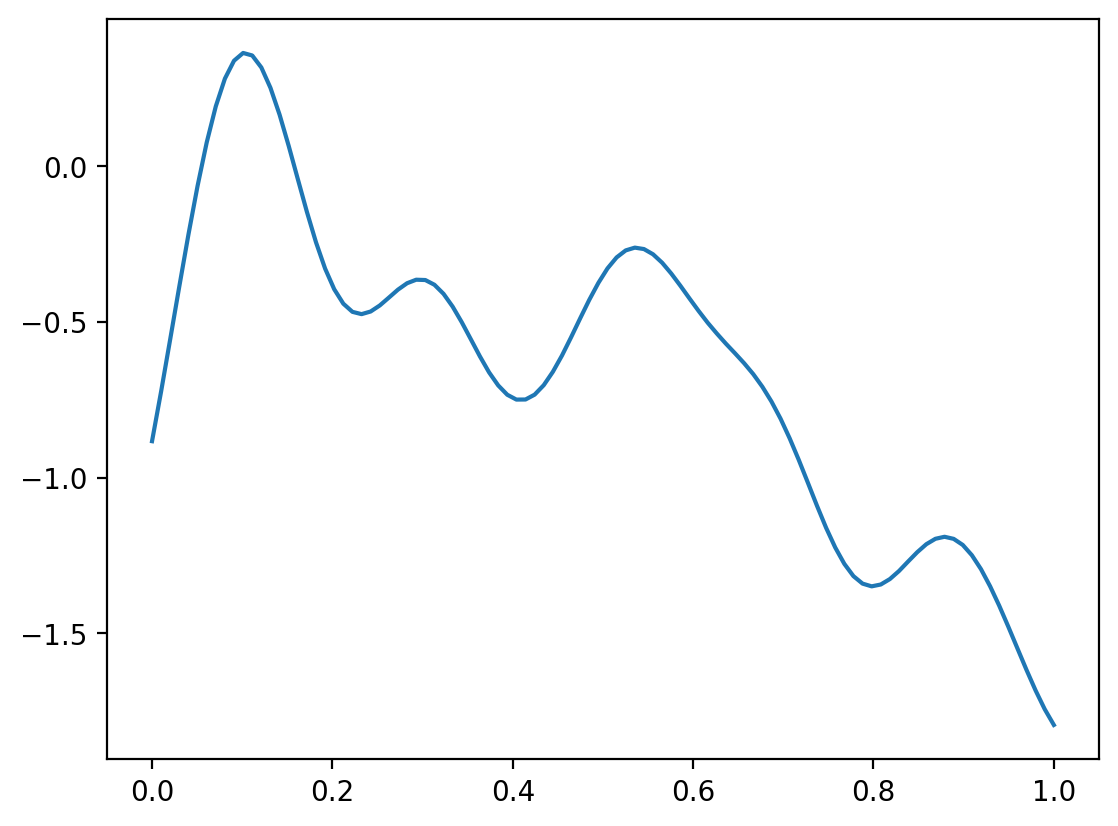

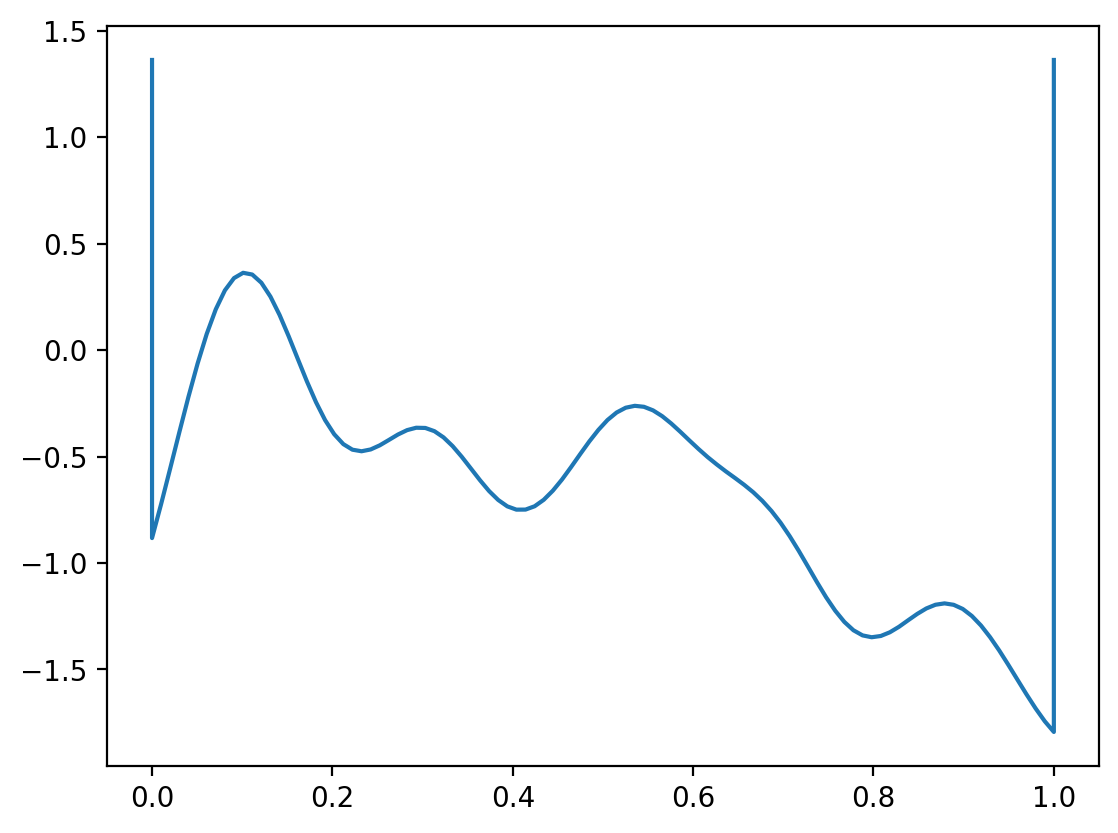

In [478]:
plt.plot(x, fs.T)

plt.figure(); plt.plot(x_pad, fs_pad.T)


In [480]:
np.column_stack((x_pad, fs_pad[0, :]))

array([[ 0.        ,  1.36316611],
       [ 0.        , -0.88312557],
       [ 0.01010101, -0.72292924],
       [ 0.02020202, -0.55495096],
       [ 0.03030303, -0.38529361],
       [ 0.04040404, -0.2191482 ],
       [ 0.05050505, -0.06349589],
       [ 0.06060606,  0.07556783],
       [ 0.07070707,  0.1918512 ],
       [ 0.08080808,  0.28079796],
       [ 0.09090909,  0.33826262],
       [ 0.1010101 ,  0.36316611],
       [ 0.11111111,  0.35503808],
       [ 0.12121212,  0.31653636],
       [ 0.13131313,  0.25116452],
       [ 0.14141414,  0.16523367],
       [ 0.15151515,  0.06507564],
       [ 0.16161616, -0.04136969],
       [ 0.17171717, -0.14687991],
       [ 0.18181818, -0.2447324 ],
       [ 0.19191919, -0.32908876],
       [ 0.2020202 , -0.39536098],
       [ 0.21212121, -0.44173497],
       [ 0.22222222, -0.4679112 ],
       [ 0.23232323, -0.47528453],
       [ 0.24242424, -0.46679278],
       [ 0.25252525, -0.44741873],
       [ 0.26262626, -0.4221945 ],
       [ 0.27272727,

In [481]:
fs_pad[0, :]

array([ 1.36316611, -0.88312557, -0.72292924, -0.55495096, -0.38529361,
       -0.2191482 , -0.06349589,  0.07556783,  0.1918512 ,  0.28079796,
        0.33826262,  0.36316611,  0.35503808,  0.31653636,  0.25116452,
        0.16523367,  0.06507564, -0.04136969, -0.14687991, -0.2447324 ,
       -0.32908876, -0.39536098, -0.44173497, -0.4679112 , -0.47528453,
       -0.46679278, -0.44741873, -0.4221945 , -0.3965618 , -0.37599468,
       -0.36476544, -0.36578034, -0.38093394, -0.41005903, -0.45114043,
       -0.50116535, -0.55605518, -0.61117209, -0.66216509, -0.70402504,
       -0.73408549, -0.74958022, -0.7492956 , -0.7337132 , -0.70331541,
       -0.66047831, -0.60833746, -0.54971201, -0.48881984, -0.42932823,
       -0.37499334, -0.32847312, -0.29319546, -0.27067861, -0.26177737,
       -0.26635054, -0.28315156, -0.31028677, -0.3449933 , -0.38406054,
       -0.42490164, -0.46489902, -0.5028473 , -0.53743281, -0.57013195,
       -0.60100245, -0.6328625 , -0.66782769, -0.70836971, -0.75

# Computations


Compare:
* 1d and 2d convex hull constructions
* biconjugate computation
* qhull + something

# 1D vs 2D

Time the current biconjugate computation

QhullError: QH6154 Qhull precision error: Initial simplex is flat (facet 2 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 628983247  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 2.7e+161  Error-roundoff 1.8e+146  _one-merge 9.2e+146
  _near-inside 4.6e+147  Visible-distance 3.7e+146  U-max-coplanar 3.7e+146
  Width-outside 7.3e+146  _wide-facet 2.2e+147  _maxoutside 1.1e+147

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p101(v3):     1 2.7e+161
- p100(v2):     1   1.1
- p0(v1):     0   2.1

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 1.8e+146.  The center point, facets and distances
to the center point are as follows:

center point   0.6667 9.124e+160

facet p100 p0 distance= -6.5e+160
facet p101 p0 distance=    0
facet p101 p100 distance=    0

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

The min and max coordinates for each dimension are:
  0:         0         1  difference=    1
  1:    -1.728  2.737e+161  difference= 2.737e+161

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 1.8e+146.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.


NameError: name 'hullvals' is not defined

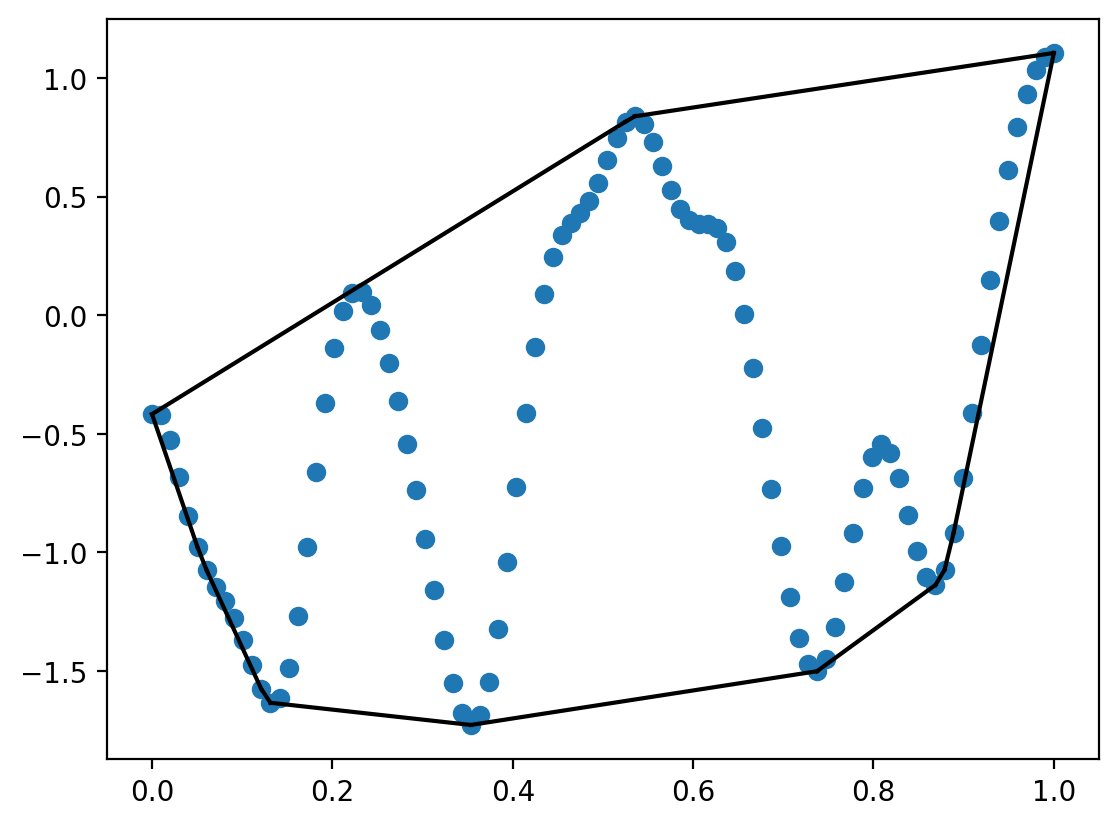

In [6]:
seed = 2
num_iters = 6
knot_N = 100
npr.seed(seed); rng_key = jrnd.PRNGKey(seed)

# grid to discretize design space into
knot_x = jnp.linspace(0, 1, knot_N)
design_space = knot_x[:, jnp.newaxis]

for ind in range(1):
    true_y, true_envelope = generate_true_function(design_space, knot_N)
    
    plt.figure(); plt.scatter(design_space, true_y)
    points = np.hstack([design_space, true_y[:, np.newaxis]])
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
        
    %time hullvals = convex_envelope(design_space, true_y)

    for i in hullvals:
        plt.scatter(design_space[i], true_y[i], c="tab:red", marker="x", s=200)
        
    
    %time hull2 = convelope(design_space, true_y)[0]
    tights2 = np.abs(hull2 - true_y) <= 1e-3
    
    for i, val in enumerate(tights2):
        if val == True:
            plt.scatter(design_space[i], true_y[i], marker="o", c="tab:green")

In [ ]:
tightset = set(hullvals) 
simps = []
for i, simplex in enumerate(hull.simplices):
    if (simplex[0] in tightset) and (simplex[1] in tightset):
         simps.append(simplex)

In [504]:
tightset

{0, 32, 33, 34, 53, 54, 88, 89, 90, 91, 92, 93, 99}

In [502]:
hull.simplices

array([[32,  0],
       [54, 99],
       [ 1,  0],
       [ 1, 88],
       [33, 34],
       [33, 32],
       [53, 34],
       [53, 54],
       [93, 99],
       [89, 88],
       [92, 91],
       [92, 93],
       [90, 91],
       [90, 89]], dtype=int32)

In [501]:
simps

[array([32,  0], dtype=int32),
 array([54, 99], dtype=int32),
 array([33, 34], dtype=int32),
 array([33, 32], dtype=int32),
 array([53, 34], dtype=int32),
 array([53, 54], dtype=int32),
 array([93, 99], dtype=int32),
 array([89, 88], dtype=int32),
 array([92, 91], dtype=int32),
 array([92, 93], dtype=int32),
 array([90, 91], dtype=int32),
 array([90, 89], dtype=int32)]

CPU times: user 3.24 ms, sys: 250 µs, total: 3.49 ms
Wall time: 3.58 ms


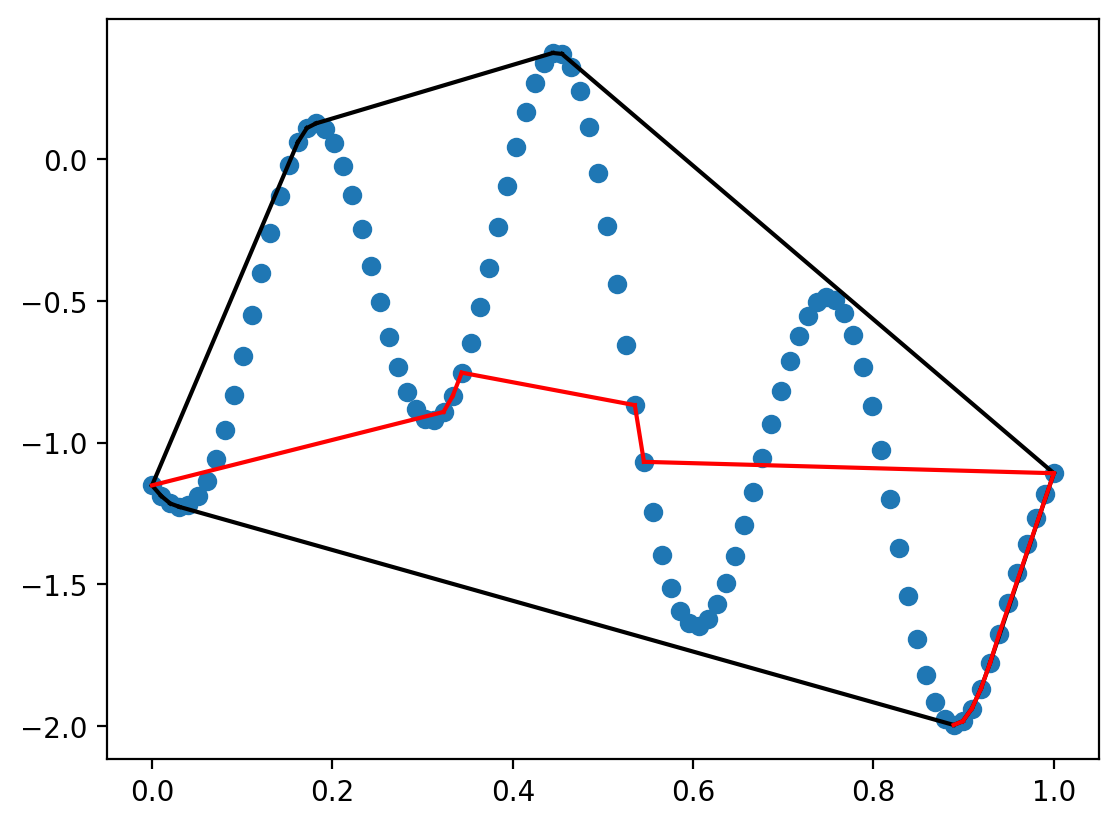

In [503]:
true_y, true_envelope = generate_true_function(design_space, knot_N)
    
plt.figure(); plt.scatter(design_space, true_y)
points = np.hstack([design_space, true_y[:, np.newaxis]])
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
    
for simplex in simps:
     plt.plot(points[simplex, 0], points[simplex, 1], 'r-')

%time hullvals = convex_envelope(design_space, true_y)

In [397]:
"""
plt.plot(design_space, true_y)
plt.plot(design_space, true_envelope.T)

s = is_tight(design_space, true_y).astype("int32")
s_ind = np.where(s == 1)[0]
plt.scatter(design_space[s_ind], true_y[s_ind])
"""

'\nplt.plot(design_space, true_y)\nplt.plot(design_space, true_envelope.T)\n\ns = is_tight(design_space, true_y).astype("int32")\ns_ind = np.where(s == 1)[0]\nplt.scatter(design_space[s_ind], true_y[s_ind])\n'

Array([[ 1.1615215 ,  1.02533075,  0.88914   ,  0.75294925,  0.617969  ,
         0.48423214,  0.35049528,  0.2441546 ,  0.13986439,  0.03557417,
        -0.06871604, -0.17300625, -0.27729647, -0.38158668, -0.48587689,
        -0.59016711, -0.69445732, -0.79874753, -0.90303774, -1.00732796,
        -1.11161817, -1.21590838, -1.3201986 , -1.33029474, -1.30452892,
        -1.27876311, -1.25299729, -1.22723147, -1.20146565, -1.17569984,
        -1.14993402, -1.1241682 , -1.09840239, -1.07263657, -1.04687075,
        -1.02110493, -0.99533912, -0.9695733 , -0.94380748, -0.91804166,
        -0.89227585, -0.86651003, -0.84074421, -0.81497839, -0.78921258,
        -0.7623855 , -0.73416579, -0.70594609, -0.67772638, -0.64005233]],      dtype=float64)

In [404]:
%timeit convelope(design_space, true_y)

2.07 ms ± 66.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [405]:
%timeit convex_envelope(design_space, true_y)

2.19 ms ± 162 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [392]:
"""
def get_tight(design_space, true_y):
    points = np.hstack([design_space, true_y[:, np.newaxis]])
    hull = ConvexHull(points)
    s = np.zeros(len(design_space))
    s[hull.vertices] = 1
    return s
"""

## 2D

In [7]:
n_grid = 11

nx, ny = (n_grid, n_grid)
x = jnp.linspace(0, 1, nx)
y = jnp.linspace(0, 1, ny)
xv, yv = jnp.meshgrid(x, y)
train_x = jnp.array([xv.flatten(),yv.flatten()]).T
# filter out points that are greater than 1
design_space = train_x[train_x.sum(1) <= 1]
pts = []
for x in design_space:
    pts.append(jnp.array([x[0], x[1], 1-x.sum()]))
    
knot_N = len(design_space)

#set seed
seed = 5
npr.seed(seed); rng_key = jrnd.PRNGKey(seed)

# generate energies
true_y, true_envelope = generate_true_function(design_space, knot_N)

# compute tight points w.r.t. generated data
tights = (true_y - true_envelope) <= 1e-3
tight_designs = design_space[tights.ravel(),:]
tight_pts = []
for x in tight_designs:
    tight_pts.append(jnp.array([x[0], x[1], 1-x.sum()]))

# observations at each vertex and roughly in the middle
train_x = jnp.array([design_space[0], design_space[10], design_space[24], design_space[-1]])
train_y = jnp.array([true_y[0], true_y[10], true_y[24], true_y[-1]])
data = (train_x, train_y); #dataset = Dataset(X=train_x, y=train_y[:,jnp.newaxis])

In [8]:
%timeit convelope(design_space, true_y)

210 ms ± 3.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%timeit is_tight(design_space, true_y)

551 µs ± 39.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [10]:
%timeit convex_envelope(design_space, true_y)

2.23 ms ± 77.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
[[c1, c2], [c1, c2],
        ...]

In [32]:
data = {'concentration': design_space,
        'mixing_energy': true_y}

#data = {'concentration': [0,    0.2,  0.2,  0.3,  0.4,  0.5,  0.8,  1.0],
#        'mixing_energy': [0.1, -0.2, -0.1, -0.2,  0.2, -0.4, -0.2, -0.1]}

%timeit hull = ConvexHullMod(data['concentration'], data['mixing_energy'])

#plt.scatter(data['concentration'], data['mixing_energy'], color='darkred')
#plt.plot(hull.concentrations, hull.energies)

#low_energy_structures = hull.extract_low_energy_structures(
 #       data['concentration'], data['mixing_energy'],
 #       energy_tolerance=0.005)

#low_energy_structures

hull.concentrations
hull.energies

5.4 ms ± 214 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


array([ 0.44122749, -0.26811246, -1.22657544, -1.54136703, -1.32759361,
       -0.87665466, -0.87594164, -0.10005816])

In [34]:
hull.structures

[0, 1, 10, 14, 18, 21, 63, 65]

In [ ]:
>>> 
        >>> 
    Now one can for example access the points along the convex hull directly::
        >>> for c, e in zip(hull.concentrations, hull.energies):
        ...     print(c, e)
        0.0 0.1
        0.2 -0.2
        0.5 -0.4
        1.0 -0.1
    or plot the convex hull along with the original data using e.g., matplotlib::
        >>> import matplotlib.pyplot as plt
        >>> plt.scatter(data['concentration'], data['mixing_energy'], color='darkred')
        >>> plt.plot(hull.concentrations, hull.energies)
        >>> plt.show(block=False)
    It is also possible to extract structures at or close to the convex hull::
        >>> low_energy_structures = hull.extract_low_energy_structures(
        ...     data['concentration'], data['mixing_energy'],
        ...     energy_tolerance=0.005)

In [9]:
chull = convelope(design_space, true_y)

In [20]:
chull2 = convex_envelope_old(design_space, true_y)

Text(0.5, 0, 'energy')

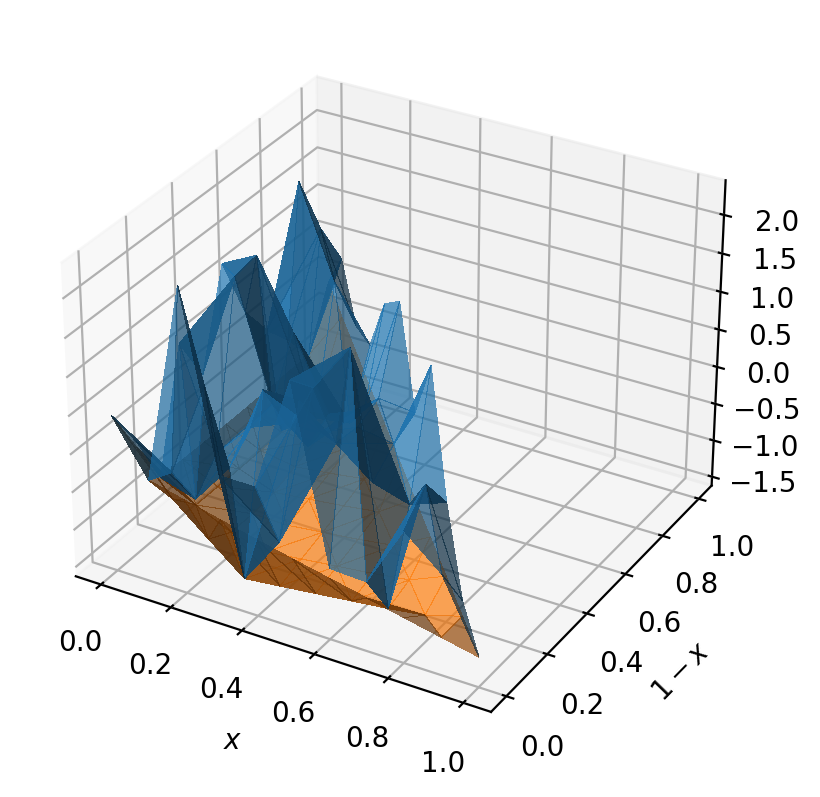

In [11]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot_trisurf(design_space[:,0], design_space[:,1], true_y, linewidth=0, antialiased=False, alpha=0.7)
ax.plot_trisurf(design_space[:,0], design_space[:,1], chull.ravel(), linewidth=0, antialiased=False, alpha=0.7)


ax.set_xlabel("$x$"); ax.set_ylabel("$1-x$"); ax.set_zlabel("energy")

In [29]:
chull2

array([ 0,  1,  5,  9, 10, 14, 17, 18, 21, 37, 63, 65])

In [24]:
true_y[chull2]

Array([ 0.44122749, -0.26811246,  1.58253809, -0.30135891, -1.22657544,
       -1.54136703,  1.88591852, -1.32759361, -0.87665466,  1.33002785,
       -0.87594164, -0.10005816], dtype=float64)

Text(0.5, 0, 'energy')

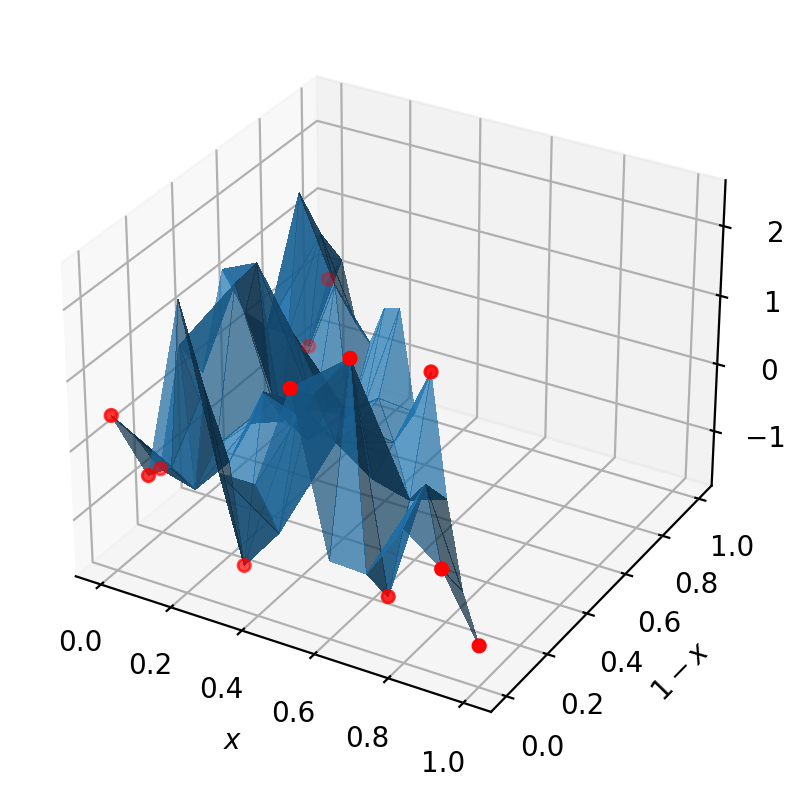

In [28]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot_trisurf(design_space[:,0], design_space[:,1], true_y, linewidth=0, antialiased=False, alpha=0.7)
#ax.plot_trisurf(design_space[chull2,0], design_space[chull2,1], true_y[chull2], linewidth=0, antialiased=False, alpha=0.7)

#ax.scatter(design_space[chull2][:,0], design_space[chull2][:,1], true_y[chull2], c="red")

#ax.plot_trisurf(design_space[chull2,0], design_space[chull2,1], true_y[chull2], linewidth=0, antialiased=False, alpha=0.7)


ax.set_xlabel("$x$"); ax.set_ylabel("$1-x$"); ax.set_zlabel("energy")

Text(0.5, 0, 'energy')

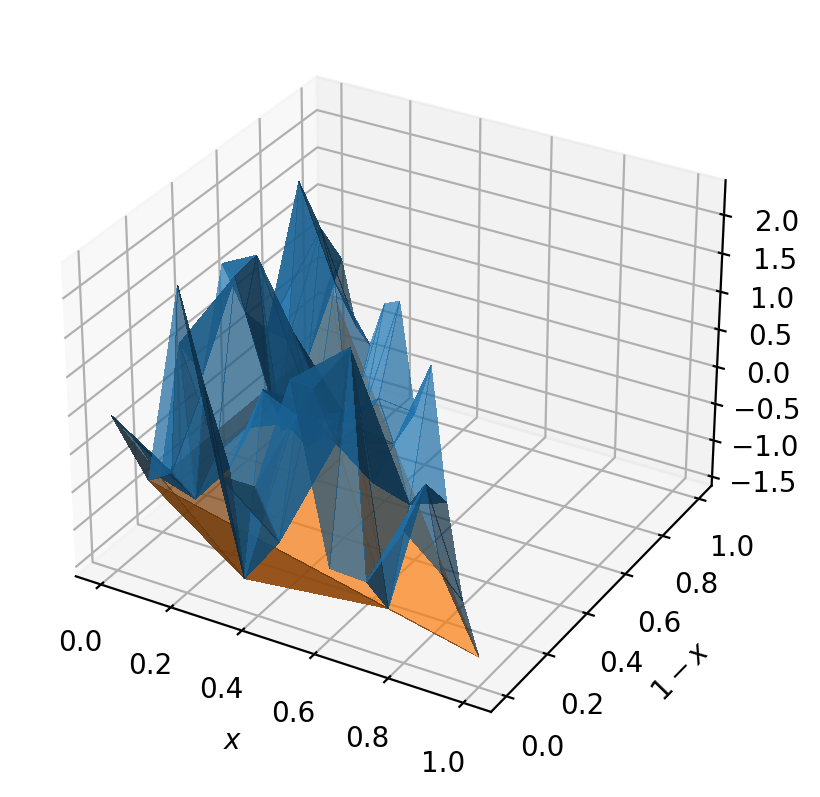

In [30]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot_trisurf(design_space[:,0], design_space[:,1], true_y, linewidth=0, antialiased=False, alpha=0.7)
#ax.plot_trisurf(design_space[chull2,0], design_space[chull2,1], true_y[chull2], linewidth=0, antialiased=False, alpha=0.7)

#ax.scatter(design_space[chull2][:,0], design_space[chull2][:,1], true_y[chull2], c="red")

ax.plot_trisurf(hull.concentrations[:, 0], hull.concentrations[:, 1], hull.energies, linewidth=0, antialiased=False, alpha=0.7)


ax.set_xlabel("$x$"); ax.set_ylabel("$1-x$"); ax.set_zlabel("energy")

In [29]:
hull.concentrations[:, 1].shape

(8,)

In [ ]:
def convex_envelope(x, fs):
    """Computes convex envelopes of M functions which share a common grid.
    x is an (N, D)-matrix corresponding to the grid in D-dimensional space and fs is an (M, N)-matrix.
    The i-th function is given by the pairs (x[0], fs[i, 0]), ..., (x[N-1], fs[i, N-1]).
    The envelopes are returned as a list of lists.
    The i-th list is of the form [j_1, j_2, ..., j_n] where (X[j_k], fs[i, j_k]) is a point in the envelope.
    
    Keyword arguments:
    x  -- A shape=(N,D) numpy array.
    fs -- A shape=(M,N) or shape=(N,) numpy array."""
    
    #assert(len(fs.shape) <= 2)
    if len(fs.shape) == 1: fs = np.reshape(fs, (-1, fs.shape[0]))
    M, N = fs.shape
    
    assert(len(x.shape) <= 2)
    if len(x.shape) == 1: x = np.reshape(x, (-1, 1))
    assert(x.shape[0] == N)
    D = x.shape[1]
    
    fs_pad = np.empty((M, N+2))
    fs_pad[:, 1:-1], fs_pad[:, (0,-1)] = fs, np.max(fs) + 1. ## TODO: can't do this
    
    x_pad = np.empty((N+2, D))
    x_pad[1:-1, :], x_pad[0, :], x_pad[-1, :] = x, x[0, :], x[-1, :]
    
    results = []
    for i in range(M):
        epi = np.column_stack((x_pad, fs_pad[i, :]))
        hull = ConvexHull(epi)
        result = [v-1 for v in hull.vertices if 0 < v <= N]
        result.sort()
        results.append(np.array(result))
    
    return np.array(results)

In [ ]:
convex_envelope(points[:, :-1], points[:, -1])

In [ ]:
points[:, :-1].shape

In [ ]:
true_y.shape

In [ ]:
def is_vertex(points):
    N, D = points.shape
    #vertices = ConvexHull(points).vertices
    vertices = convex_envelope(points[:, :-1], points[:, -1])[0]
    s = np.zeros(N)
    s[vertices] = 1
    return s
    
    
def is_tight(design_space, true_y):

    points = jnp.hstack([design_space, true_y[:, jnp.newaxis]])
    #hull = ConvexHull(points)
    _scipy_hull = lambda points: is_vertex(points) #.astype(points.dtype)
    #s = np.zeros(len(design_space))
    #s[hull.vertices] = 1

    result_shape_dtype = jax.ShapeDtypeStruct(
          shape=jnp.broadcast_shapes(true_y.shape),
          dtype='float64')

    return jax.pure_callback(_scipy_hull, result_shape_dtype, points, vectorized=True)

In [ ]:
is_tight(design_space, true_y)

In [ ]:
chull2[0]

In [ ]:
true_y[chull2]

In [ ]:
def jv(v, z):
    import scipy
    v, z = jnp.asarray(v), jnp.asarray(z)

    # Require the order v to be integer type: this simplifies
    # the JVP rule below.
    assert jnp.issubdtype(v.dtype, jnp.integer)

    # Promote the input to inexact (float/complex).
    # Note that jnp.result_type() accounts for the enable_x64 flag.
    z = z.astype(jnp.result_type(float, z.dtype))

    # Wrap scipy function to return the expected dtype.
    _scipy_jv = lambda v, z: scipy.special.jv(v, z).astype(z.dtype)

    # Define the expected shape & dtype of output.
    result_shape_dtype = jax.ShapeDtypeStruct(
      shape=jnp.broadcast_shapes(v.shape, z.shape),
      dtype=z.dtype)

    # We use vectorize=True because scipy.special.jv handles broadcasted inputs.
    return jax.pure_callback(_scipy_jv, result_shape_dtype, v, z, vectorized=True)

In [ ]:
import scipy

In [ ]:
v = jnp.asarray(1)
z = jnp.arange(5.0)

_scipy_jv = lambda v, z: scipy.special.jv(v, z).astype(z.dtype)

result_shape_dtype = jax.ShapeDtypeStruct(
      shape=jnp.broadcast_shapes(v.shape, z.shape),
      dtype=z.dtype)

output = jax.pure_callback(_scipy_jv, result_shape_dtype, v, z, vectorized=True)

In [ ]:
z.shape

In [ ]:
_scipy_jv(1, z).shape

In [ ]:
from functools import partial
j1 = partial(jv, 1)
z = jnp.arange(5.0)
print(jax.vmap(j1)(z))


In [ ]:
def get_tight(design_space, true_y):
    design_np = np.array(design_space)
    true_y_np = np.array(true_y)
    points = np.hstack([design_np, true_y_np[:, np.newaxis]])
    
    _scipy_hull = lambda points: ConvexHull(points).astype(points.dtype)
    #_scipy_jv = lambda v, z: scipy.special.jv(v, z).astype(z.dtype)
    s = np.zeros(len(design_space))
    s[np.array(hull.vertices)] = 1
    return jnp.array(s)

In [ ]:
_scipy_hull = lambda points: ConvexHull(points).astype(points.dtype)

In [ ]:
wrap_get_tight = lambda a, b: jnp.array(get_tight(a, b))

In [38]:
output = wrap_get_tight(design_space, true_y)

get_tight_jax = jax.vmap(wrap_get_tight, in_axes=(0,None))

NameError: name 'wrap_get_tight' is not defined

In [39]:
all_designs = jnp.array([design_space, design_space])
all_ys = jnp.array([true_y, true_y])

In [40]:
np.array(design_space)

array([[0. , 0. ],
       [0.1, 0. ],
       [0.2, 0. ],
       [0.3, 0. ],
       [0.4, 0. ],
       [0.5, 0. ],
       [0.6, 0. ],
       [0.7, 0. ],
       [0.8, 0. ],
       [0.9, 0. ],
       [1. , 0. ],
       [0. , 0.1],
       [0.1, 0.1],
       [0.2, 0.1],
       [0.3, 0.1],
       [0.4, 0.1],
       [0.5, 0.1],
       [0.6, 0.1],
       [0.7, 0.1],
       [0.8, 0.1],
       [0.9, 0.1],
       [0. , 0.2],
       [0.1, 0.2],
       [0.2, 0.2],
       [0.3, 0.2],
       [0.4, 0.2],
       [0.5, 0.2],
       [0.6, 0.2],
       [0.7, 0.2],
       [0.8, 0.2],
       [0. , 0.3],
       [0.1, 0.3],
       [0.2, 0.3],
       [0.3, 0.3],
       [0.4, 0.3],
       [0.5, 0.3],
       [0.6, 0.3],
       [0.7, 0.3],
       [0. , 0.4],
       [0.1, 0.4],
       [0.2, 0.4],
       [0.3, 0.4],
       [0.4, 0.4],
       [0.5, 0.4],
       [0.6, 0.4],
       [0. , 0.5],
       [0.1, 0.5],
       [0.2, 0.5],
       [0.3, 0.5],
       [0.4, 0.5],
       [0.5, 0.5],
       [0. , 0.6],
       [0.1,